# Notebook 2 - Exploring the Data

In this notebook, we will explore the prepared baseball data by looking at various visualizations and plot types.

First, let's import the necessary libraries and load the prepared data.

In [37]:
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
path = kagglehub.dataset_download("open-source-sports/baseball-databank")
# Load the necessary CSV files
teams = pd.read_csv("/Users/willgurley/.cache/kagglehub/datasets/open-source-sports/baseball-databank/versions/2/Teams.csv")
salaries = pd.read_csv("/Users/willgurley/.cache/kagglehub/datasets/open-source-sports/baseball-databank/versions/2/Salaries.csv")

# Filter teams to post-1985 (when salary data becomes available)
teams_post_1985 = teams[teams['yearID'] >= 1985]

# Aggregate salaries by team and year, counting each player once per team-year
# Drop duplicate player entries within the same team and year (playerID, teamID, yearID)
salaries_unique = salaries.drop_duplicates(subset=['playerID','teamID','yearID'])
# Sum salaries per team and year
team_year_salary = salaries_unique.groupby(['teamID','yearID'], as_index=False)['salary'].sum()
# Rename columns for clarity
team_year_salary = team_year_salary.rename(columns={'teamID':'team_id','yearID':'year','salary':'total_salary'})
# Sort values
team_year_salary = team_year_salary.sort_values(['year','team_id']).reset_index(drop=True)

# Compute total wins per team and year from teams_post_1985
wins = teams_post_1985.groupby(['teamID','yearID'], as_index=False)['W'].sum()
wins = wins.rename(columns={'teamID':'team_id','yearID':'year','W':'wins'})

# Merge wins into team_year_salary
df = team_year_salary.merge(wins, on=['team_id','year'], how='left')
# Fill missing wins with 0 (if a team has salary record but no teams entry)
df['wins'] = df['wins'].fillna(0).astype(int)

# Merge playoff series win data from teams dataframe
# Get playoff win columns (DivWin, WCWin, LgWin, WSWin) from teams_post_1985
playoff_wins = teams_post_1985[['teamID', 'yearID', 'DivWin', 'WCWin', 'LgWin', 'WSWin']].copy()
playoff_wins = playoff_wins.rename(columns={'teamID': 'team_id', 'yearID': 'year'})

# Convert playoff win columns to boolean (True if 'Y', False otherwise)
playoff_wins['div_win'] = (playoff_wins['DivWin'] == 'Y')
playoff_wins['wc_win'] = (playoff_wins['WCWin'] == 'Y')
playoff_wins['lg_win'] = (playoff_wins['LgWin'] == 'Y')
playoff_wins['ws_win'] = (playoff_wins['WSWin'] == 'Y')

# Get total playoff games won from SeriesPost.csv
series_post = pd.read_csv("/Users/willgurley/.cache/kagglehub/datasets/open-source-sports/baseball-databank/versions/2/SeriesPost.csv")
series_post = series_post[series_post['yearID'] >= 1985]

# Calculate playoff games won by winners (wins column)
winner_games = series_post.groupby(['yearID', 'teamIDwinner'], as_index=False)['wins'].sum()
winner_games = winner_games.rename(columns={'yearID': 'year', 'teamIDwinner': 'team_id', 'wins': 'games_won'})

# Calculate playoff games won by losers (losses column - this is games the loser won)
loser_games = series_post.groupby(['yearID', 'teamIDloser'], as_index=False)['losses'].sum()
loser_games = loser_games.rename(columns={'yearID': 'year', 'teamIDloser': 'team_id', 'losses': 'games_won'})

# Combine both and sum total playoff games won per team per year
all_playoff_games = pd.concat([winner_games, loser_games], ignore_index=True)
total_playoff_games = all_playoff_games.groupby(['year', 'team_id'], as_index=False)['games_won'].sum()
total_playoff_games = total_playoff_games.rename(columns={'games_won': 'total_playoff_wins'})

# Merge with playoff_wins
playoff_wins = playoff_wins.merge(total_playoff_games, on=['team_id', 'year'], how='left')
playoff_wins['total_playoff_wins'] = playoff_wins['total_playoff_wins'].fillna(0).astype(int)

# Merge with df dataframe
df = df.merge(playoff_wins[['team_id', 'year', 'div_win', 'wc_win', 'lg_win', 'ws_win', 'total_playoff_wins']], 
                      on=['team_id', 'year'], 
                      how='left')

# Fill NaN values (teams that didn't make playoffs)
df['div_win'] = df['div_win'].fillna(False)
df['wc_win'] = df['wc_win'].fillna(False)
df['lg_win'] = df['lg_win'].fillna(False)
df['ws_win'] = df['ws_win'].fillna(False)
df['total_playoff_wins'] = df['total_playoff_wins'].fillna(0).astype(int)

# Create df (same as df at this point)
df = df.copy()

df.head()


,team_id,year,total_salary,wins,div_win,wc_win,lg_win,ws_win,total_playoff_wins
0,ATL,1985,14807000,66,False,False,False,False,0
1,BAL,1985,11560712,83,False,False,False,False,0
2,BOS,1985,10897560,81,False,False,False,False,0
3,CAL,1985,14427894,90,False,False,False,False,0
4,CHA,1985,9846178,85,False,False,False,False,0


### Preliminary Visualizations

<Axes: xlabel='total_salary', ylabel='wins'>

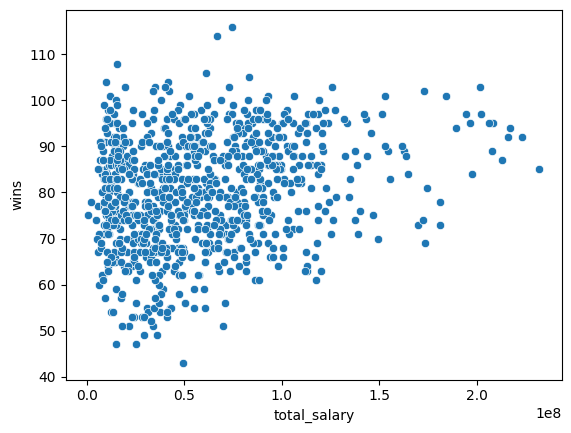

In [38]:
# Scatter plot of total wins vs. total salary
sns.scatterplot(x='total_salary', y='wins', data=df)

<Axes: xlabel='year', ylabel='total_salary'>

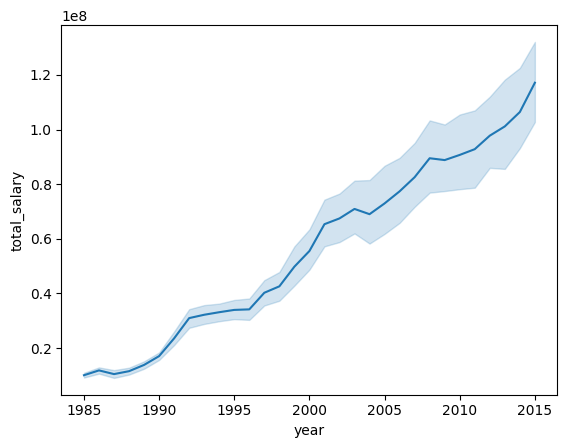

In [39]:
# total salary by year
sns.lineplot(x='year', y='total_salary', data=df)

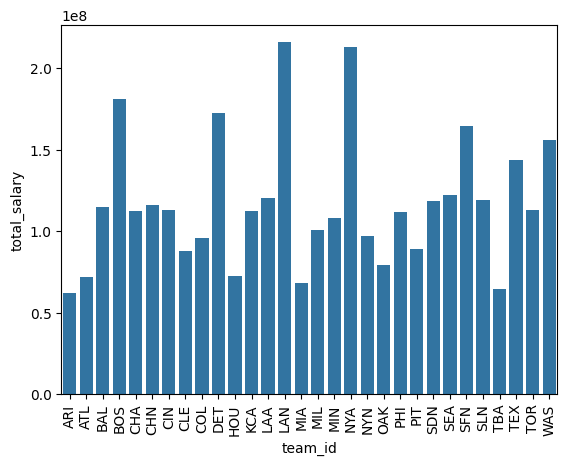

In [40]:
# total salary by team in 2015
sns.barplot(x='team_id', y='total_salary', data=df[df['year'] == 2015])
plt.xticks(rotation=90)
plt.show()

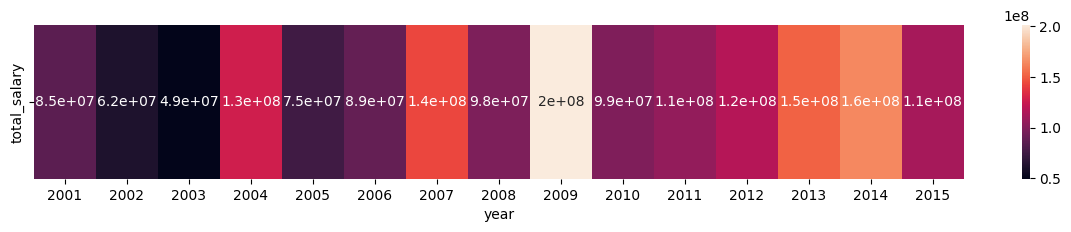

In [41]:
# heatmap of world series winners shaded by salary from 2001-2015
# Filter to World Series winners from 2001-2015
ws_winners_2001_2015 = df[(df['ws_win'] == True) & (df['year'] >= 2001) & (df['year'] <= 2015)]

heatmap_data = ws_winners_2001_2015.set_index('year')['total_salary'].to_frame().T
heatmap_data.columns = heatmap_data.columns.astype(str)

# Create the heatmap
plt.figure(figsize=(15, 2))
sns.heatmap(heatmap_data, 
            annot=True, )
plt.show()



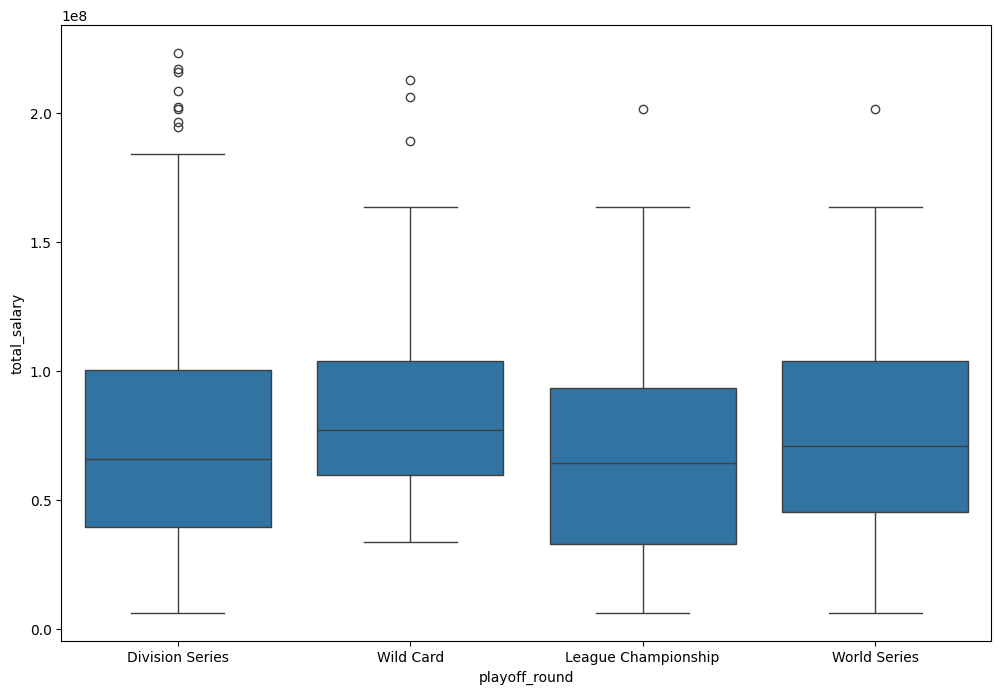

In [42]:
# box plots of salary by playoff series
# Reshape data to show salary distribution for each playoff round
# Create a list to store data for each playoff round
playoff_data_list = []

# For each playoff round, get teams that won that round
for playoff_round, column in [('Division Series', 'div_win'), 
                               ('Wild Card', 'wc_win'), 
                               ('League Championship', 'lg_win'), 
                               ('World Series', 'ws_win')]:
    # Filter to teams that won this playoff round
    round_winners = df[df[column] == True].copy()
    if len(round_winners) > 0:
        round_winners['playoff_round'] = playoff_round
        playoff_data_list.append(round_winners[['playoff_round', 'total_salary']])

# Combine all playoff rounds into one dataframe
playoff_salary_data = pd.concat(playoff_data_list, ignore_index=True)


# Create boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=playoff_salary_data, 
            x='playoff_round', 
            y='total_salary')

plt.show()





### Final Visualizations

#### Scatterplot

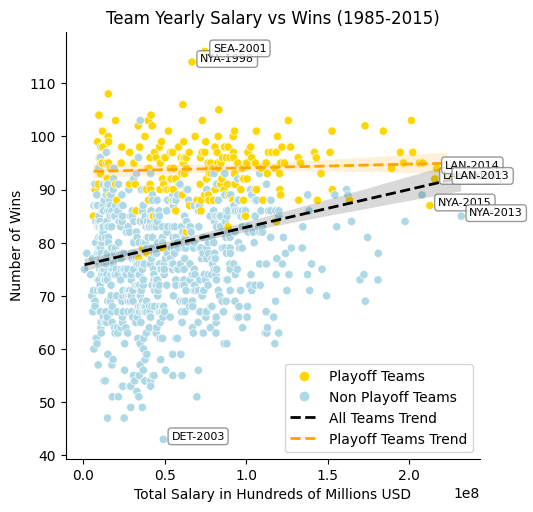

In [43]:
df = df.sort_values('total_salary')
winners = df[df['wins'] >= 110]
losers = df[df['wins'] <= 45]
spenders = df[df['total_salary'] >= 210_000_000]
df['playoff_teams'] = df['div_win'] | df['wc_win'] | df['lg_win'] | df['ws_win']

# Suppress automatic legend from relplot
g = sns.relplot(data=df, x='total_salary', y='wins',  
                palette={True: 'gold', False: 'lightblue'}, legend=False, hue = 'playoff_teams')

# Get the axes from the FacetGrid
ax = g.axes[0, 0]

# Add trend line for entire dataset (black line) with lower z-order so it's behind text
sns.regplot(data=df, x='total_salary', y='wins', 
            scatter=False, ax=ax, color='black', line_kws={'linestyle': '--', 'linewidth': 2, 'label': 'All Teams', 'zorder': 1})
# Add trend line for playoff teams
playoff_teams = df[df['playoff_teams'] == True]
sns.regplot(data=playoff_teams, x='total_salary', y='wins', 
            scatter=False, ax=ax, color='orange', line_kws={'linestyle': '--', 'linewidth': 2, 'label': 'Playoff Teams', 'zorder': 1})\

# Add text labels with higher z-order and background box so they appear above trend lines
text_bbox = dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8)
for _, row in winners.iterrows():
    plt.text(row['total_salary'] + 5000000, row['wins'], f"{row['team_id']}-{row['year']}", 
             fontsize=8, zorder=10, bbox=text_bbox)
for _, row in losers.iterrows():
    plt.text(row['total_salary'] + 5000000, row['wins'], f"{row['team_id']}-{row['year']}", 
             fontsize=8, zorder=10, bbox=text_bbox)
for _, row in spenders.iterrows():
    plt.text(row['total_salary'] + 5000000, row['wins'], f"{row['team_id']}-{row['year']}", 
             fontsize=8, zorder=10, bbox=text_bbox)

# Create custom combined legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', markersize=8, label='Playoff Teams'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=8, label='Non Playoff Teams'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='All Teams Trend'),
    Line2D([0], [0], color='orange', linestyle='--', linewidth=2, label='Playoff Teams Trend')
]
ax.legend(handles=legend_elements, loc='best')

plt.title('Team Yearly Salary vs Wins (1985-2015)')
plt.xlabel('Total Salary in Hundreds of Millions USD')
plt.ylabel('Number of Wins')
plt.show()


#### Heatmap

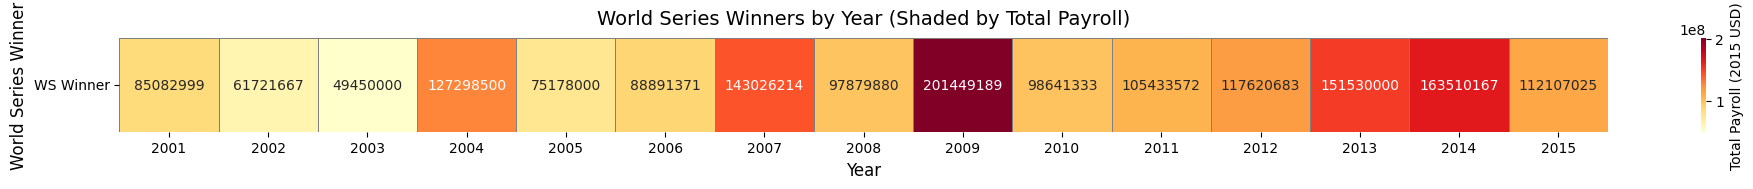

In [44]:
plt.figure(figsize=(20, 2))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.0f', 
            cmap='YlOrRd', 
            cbar_kws={'label': 'Total Payroll (2015 USD)'},
            linewidths=0.5,
            linecolor='gray')
plt.title('World Series Winners by Year (Shaded by Total Payroll)', fontsize=14, pad=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('World Series Winner', fontsize=12)
plt.yticks([0.5], ['WS Winner'], rotation=0)
plt.tight_layout()
plt.show()

#### Box Plots

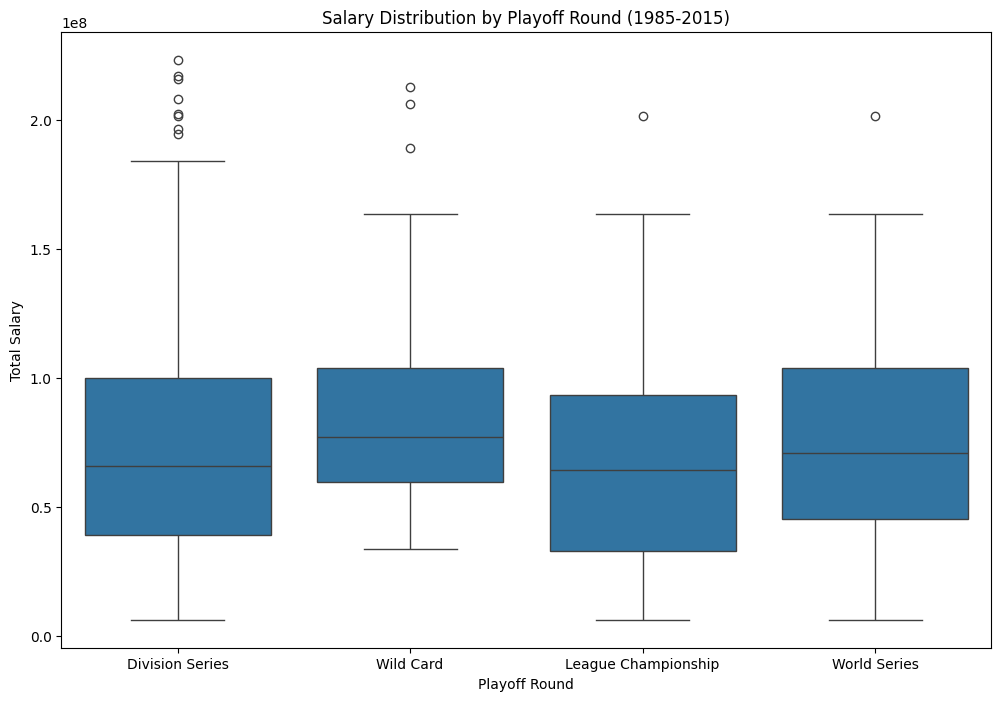

In [45]:
# Create boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=playoff_salary_data, 
            x='playoff_round', 
            y='total_salary')

plt.title('Salary Distribution by Playoff Round (1985-2015)')
plt.xlabel('Playoff Round')
plt.ylabel('Total Salary')
plt.show()